<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/YOLOv5_inference_diverse_iris_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YOLOv5 inference_diverse_iris_model**

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco

/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco


In [3]:
%%writefile requirements.txt

# pip install -r requirements.txt

# Base ----------------------------------------
matplotlib>=3.2.2
numpy>=1.18.5
opencv-python-headless>=4.6.0.66
Pillow>=7.1.2
PyYAML>=5.3.1
##requests>=2.23.0
scipy>=1.4.1
# torch>=1.7.0
# torchvision>=0.8.1
tqdm>=4.41.0

# Logging -------------------------------------
##tensorboard>=2.4.1
# wandb

# Plotting ------------------------------------
##pandas>=1.1.4
##seaborn>=0.11.0

# Export --------------------------------------
# coremltools>=4.1  # CoreML export
# onnx>=1.9.0  # ONNX export
# onnx-simplifier>=0.3.6  # ONNX simplifier
# scikit-learn==0.19.2  # CoreML quantization
# tensorflow>=2.4.1  # TFLite export
# tensorflowjs>=3.9.0  # TF.js export

# Extras --------------------------------------
# albumentations>=1.0.3
# Cython  # for pycocotools https://github.com/cocodataset/cocoapi/issues/172
# pycocotools>=2.0  # COCO mAP
# roboflow
thop  # FLOPs computation

Overwriting requirements.txt


In [4]:
!pip install -r requirements.txt

In [ ]:
#最新バージョンでも動くので削除
# !pip install torch==1.10.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install torchvision==0.11.2+cu113 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import glob
weight = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"

num = 5
img_dir = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/data"
img = glob.glob(f"{img_dir}/*")[num]
img

img = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/runs/detect/exp/APAC_fko0078.jpg"

In [ ]:
!python detect.py  --weights $weight  --source $img

# 必要な部分だけ抜粋

In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
#from utils.torch_utils import select_device, time_sync
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np


device = 'cpu'
#device = select_device(device)
model = DetectMultiBackend(weight, device="cpu", dnn=False)
#stride, names, pt, jit, onnx, engine = model.stride, model.names, model.pt, model.jit, model.onnx, model.engine
#imgsz = check_img_size([640], s=stride)  # check image size

class_names = {0:"infection", 1:"normal", 2:"non-infection", 3:"scar", 4:"tumor", 5:"deposit", 6:"APAC", 7:"lens opacity", 8:"bullous"}

# transform = transforms.Compose([
#             transforms.Resize(size=(480,640)),
#             transforms.ToTensor(),
#             # transforms.Normalize(
#             #     mean=[0.5, 0.5, 0.5],
#             #     std=[0.5, 0.5, 0.5]
#             #    )
#             ])

img_pil = Image.open(img)  #PILで開く(streamlitの仕様)
img_numpy = np.array(img_pil, dtype=np.uint8)
img_cv2 = cv2.cvtColor(img_numpy, cv2.COLOR_RGB2BGR)

#img_cv2 = cv2.imread(img)
#img_cv2 = cv2.resize(img_cv2, dsize=(480, 640)) #480*600pxにリサイズ
img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
img_cv2 = np.ascontiguousarray(img_cv2)
img_tensor = torch.from_numpy(img_cv2).float()

#img_tensor = transform(img_np)
img_tensor /= 255
# print(img_tensor.shape)
# print(img_tensor)
img_tensor = torch.unsqueeze(img_tensor, 0)  # バッチ対応


pred = model(img_tensor, visualize=False, augment=False)

# multi_label=Trueにすることにより全クラスの値のlikelihoodを取得できる。数値が低いものが省略されないようconf_thres=0にしている。
pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, classes=None , multi_label=True, max_det=1000)


# 全てのクラスとlikelihoodのペアを取得
class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(8)]

# likelihoodで降順にソート
class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

# 上位3つのクラスとlikelihoodを出力
print("Top 3 Classes and Likelihoods:")
for i in range(3):
    likelihood, class_num = class_likelihood_pairs[i]
    print(f"Class {class_num}: Likelihood {likelihood:.5f}")

Fusing layers... 
Model Summary: 213 layers, 7034398 parameters, 0 gradients, 15.8 GFLOPs


Top 3 Classes and Likelihoods:
Class 6: Likelihood 0.97141
Class 4: Likelihood 0.06582
Class 3: Likelihood 0.01356


#**Inference using Cornea journal dataset**

In [8]:
images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/taki_dr_dataset"
excel_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/corneaのスマホ判定_滝先生.xlsx"
baseline_weight_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
mixed_weight = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/2.始めから混合データセットで学習/last.pt"
finetune_mixed_weight = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/3.CorneAIを混合データセットで学習/last.pt"
finetune_100ep_weight = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/100epoch/last.pt"
finetune_150ep_weight = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/150epoch/last.pt"
finetune_200ep_weight = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/200epoch/last.pt"
finetune_250ep_weight = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/250epoch/last.pt"
finetune_300ep_weight = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/300epoch/last.pt"
finetune_350ep_weight = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/350epoch/last.pt"
finetune_400ep_weight = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/4.CorneAIを虹彩薄いデータセットで追加学習/400epoch/last.pt"

In [ ]:
import pandas as pd

# Read the Excel file starting from row 13 (which is indexed as 12 in Python) for headers
df = pd.read_excel(excel_path, header=12)

# Display the first few rows of the dataframe
df.head()

,Number,あり1なし0,備考,year,volume,...,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35
0,1,1.0,NaN,2023,42,...,NaN,NaN,NaN,NaN,NaN
1,2,1.0,薄い虹彩,2023,42,...,NaN,NaN,NaN,NaN,NaN
2,3,1.0,薄い虹彩,2023,42,...,bullous,NaN,NaN,NaN,NaN
3,4,1.0,NaN,2023,42,...,1,NaN,122.0,NaN,NaN
4,5,0.0,NaN,2022,41,...,0,NaN,15.0,NaN,NaN


In [ ]:
import os
import pandas as pd

# Assuming df is your DataFrame and it's already loaded
# df = pd.read_csv('your_dataframe.csv')  # Replace with your DataFrame loading method

# Directory path
images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/taki_dr_dataset"

# Define the columns for the new DataFrame
columns = ["image_num", "class"]

# Create an empty DataFrame with the specified columns
cornea_journal_df = pd.DataFrame(columns=columns)

# Iterating over each file in the directory
for filename in os.listdir(images_dir):
    if filename.endswith(".png"):
        # Extracting the numeric part (image number) from the filename
        image_num = int(filename.split('.')[0])

        # Match with the DataFrame and extract 'クラス' value
        matched_row = df[df['Number'] == image_num]
        if not matched_row.empty:
            class_value = matched_row['クラス'].iloc[0]
            # Creating a new row as a DataFrame
            row_data = pd.DataFrame({"image_num": [image_num], "class": [class_value]})
            # Concatenating the new row DataFrame with the main DataFrame
            cornea_journal_df = pd.concat([cornea_journal_df, row_data], ignore_index=True)

# Sort the DataFrame by the image_num column
cornea_journal_df.sort_values(by='image_num', inplace=True)

# Displaying the sorted DataFrame
print(cornea_journal_df)


    image_num class top1_baseline top2_baseline top3_baseline top1_newmodel  \
123         2     0           NaN           NaN           NaN           NaN   
126         3     0           NaN           NaN           NaN           NaN   
122         8     2           NaN           NaN           NaN           NaN   
153         9     5           NaN           NaN           NaN           NaN   
119        12     3           NaN           NaN           NaN           NaN   
..        ...   ...           ...           ...           ...           ...   
69        371     0           NaN           NaN           NaN           NaN   
76        372     5           NaN           NaN           NaN           NaN   
77        373     5           NaN           NaN           NaN           NaN   
79        374     5           NaN           NaN           NaN           NaN   
95        375     4           NaN           NaN           NaN           NaN   

    top2_newmodel top3_newmodel  
123           NaN

In [ ]:
# 画像のクラスを確認
# Getting the distribution of the 'class' column and sorting by class values
class_distribution = cornea_journal_df['class'].value_counts().sort_index()

# Displaying the distribution
print(class_distribution)

0    46
1     7
2     9
3    31
4    33
5    32
8     4
Name: class, dtype: int64


In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
#from utils.torch_utils import select_device, time_sync
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


device = 'cpu'
#model = DetectMultiBackend(orig_weight_path, device="cpu", dnn=False)
# model = DetectMultiBackend(new_weight_path, device="cpu", dnn=False)

class_names = {0:"infection", 1:"normal", 2:"non-infection", 3:"scar", 4:"tumor", 5:"deposit", 6:"APAC", 7:"lens opacity", 8:"bullous"}

def letterbox_image(image, size=(640, 480)):
    ih, iw = image.shape[:2]
    w, h = size

    # Calculate padding to maintain aspect ratio
    scale = min(w / iw, h / ih)
    nw, nh = int(scale * iw), int(scale * ih)
    image = cv2.resize(image, (nw, nh))

    # Calculate padding dimensions
    top = (h - nh) // 2
    bottom = h - nh - top
    left = (w - nw) // 2
    right = w - nw - left

    # Add padding to the image
    return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

def inference_top3(img_path, model):
    img_cv2 = cv2.imread(img_path)

    # Apply letterbox to the image
    img_cv2 = letterbox_image(img_cv2, size=(640, 480))
    #img_cv2 = cv2.resize(img_cv2,(640, 480))

    # Display the image using Matplotlib（表示させない場合はコメントアウトする）
    img_mpl = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    # Get current figure size
    fig_size = plt.gcf().get_size_inches()
    # Set new size (half the current size)
    plt.gcf().set_size_inches(fig_size[0] / 2, fig_size[1] / 2)

    plt.imshow(img_mpl)
    plt.axis('off')  # Turn off axis numbers
    plt.show()



    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    img_tensor /= 255
    img_tensor = torch.unsqueeze(img_tensor, 0)  # Add batch dimension
    pred = model(img_tensor, visualize=False, augment=False)

    # multi_label=Trueにすることにより全クラスの値のlikelihoodを取得できる。数値が低いものが省略されないようconf_thres=0にしている。
    pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, classes=None , multi_label=True, max_det=1000)

    # 全てのクラスとlikelihoodのペアを取得
    class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(8)]

    # likelihoodで降順にソート
    class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

    # 上位3つのクラスとlikelihoodを出力
    print("Top 3 Classes and Likelihoods:")
    for i in range(3):
        likelihood, class_num = class_likelihood_pairs[i]
        print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")

    top_classes = []
    for i in range(min(3, len(class_likelihood_pairs))):
        likelihood, class_num = class_likelihood_pairs[i]
        top_classes.append((class_num, likelihood))

    return top_classes

In [ ]:
#Simple inference
model = DetectMultiBackend(new_weight_path, device="cpu", dnn=False)
for num in cornea_journal_df["image_num"][0:5]:
      img = f"{images_dir}/{num}.png"
      inference_top3(img, model)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
# Baseline model
# Modify the loop to update DataFrame
model = DetectMultiBackend(baseline_weight_path, device="cpu", dnn=False)
for num in cornea_journal_df["image_num"]:
    img = f"{images_dir}/{num}.png"
    top3_results = inference_top3(img, model)

    # Update the DataFrame with the results
    for i, (class_num, likelihood) in enumerate(top3_results):
        cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_baseline'] = class_names[class_num]
        cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_baseline_likelihood'] = likelihood

In [ ]:
# New model
# Modify the loop to update DataFrame
model = DetectMultiBackend(new_weight_path, device="cpu", dnn=False)
for num in cornea_journal_df["image_num"]:
    img = f"{images_dir}/{num}.png"
    top3_results = inference_top3(img, model)

    # Update the DataFrame with the results
    for i, (class_num, likelihood) in enumerate(top3_results):
        cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_new'] = class_names[class_num]
        cornea_journal_df.loc[cornea_journal_df['image_num'] == num, f'top{i+1}_new_likelihood'] = likelihood

In [ ]:
cornea_journal_df

In [ ]:
# Define the destination path for the CSV file
dst_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/compare_accuracy.csv"

# Save the DataFrame to the CSV file
cornea_journal_df.to_csv(dst_path, index=False)

#***Analyze_results***

In [ ]:
import pandas as pd

# Assuming csv_path is the file path to your CSV file
csv_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/compare_accuracy.csv"

# Read the CSV file using pandas
df = pd.read_csv(csv_path)

# Display the first few rows of the DataFrame
df.head()


,index,image_num,class,class_name,top1_baseline,top1_baseline_likelihood,top2_baseline,top2_baseline_likelihood,top3_baseline,top3_baseline_likelihood,top1_new,top1_new_likelihood,top2_new,top2_new_likelihood,top3_new,top3_new_likelihood
0,123,2,0,infection,infection,0.865668,scar,0.038010,bullous,0.029295,infection,0.894173,tumor,0.008839,bullous,0.006174
1,126,3,0,infection,infection,0.898995,non-infection,0.008393,infection,0.001090,non-infection,0.810993,infection,0.055889,tumor,0.001463
2,122,8,2,non-infection,non-infection,0.753530,infection,0.229890,bullous,0.000850,non-infection,0.915381,infection,0.012361,tumor,0.001086
3,153,9,5,deposit,bullous,0.782418,scar,0.340283,normal,0.000619,bullous,0.708983,scar,0.582923,non-infection,0.002193
4,119,12,3,scar,scar,0.872446,deposit,0.027321,non-infection,0.014656,scar,0.695817,infection,0.160216,non-infection,0.065359


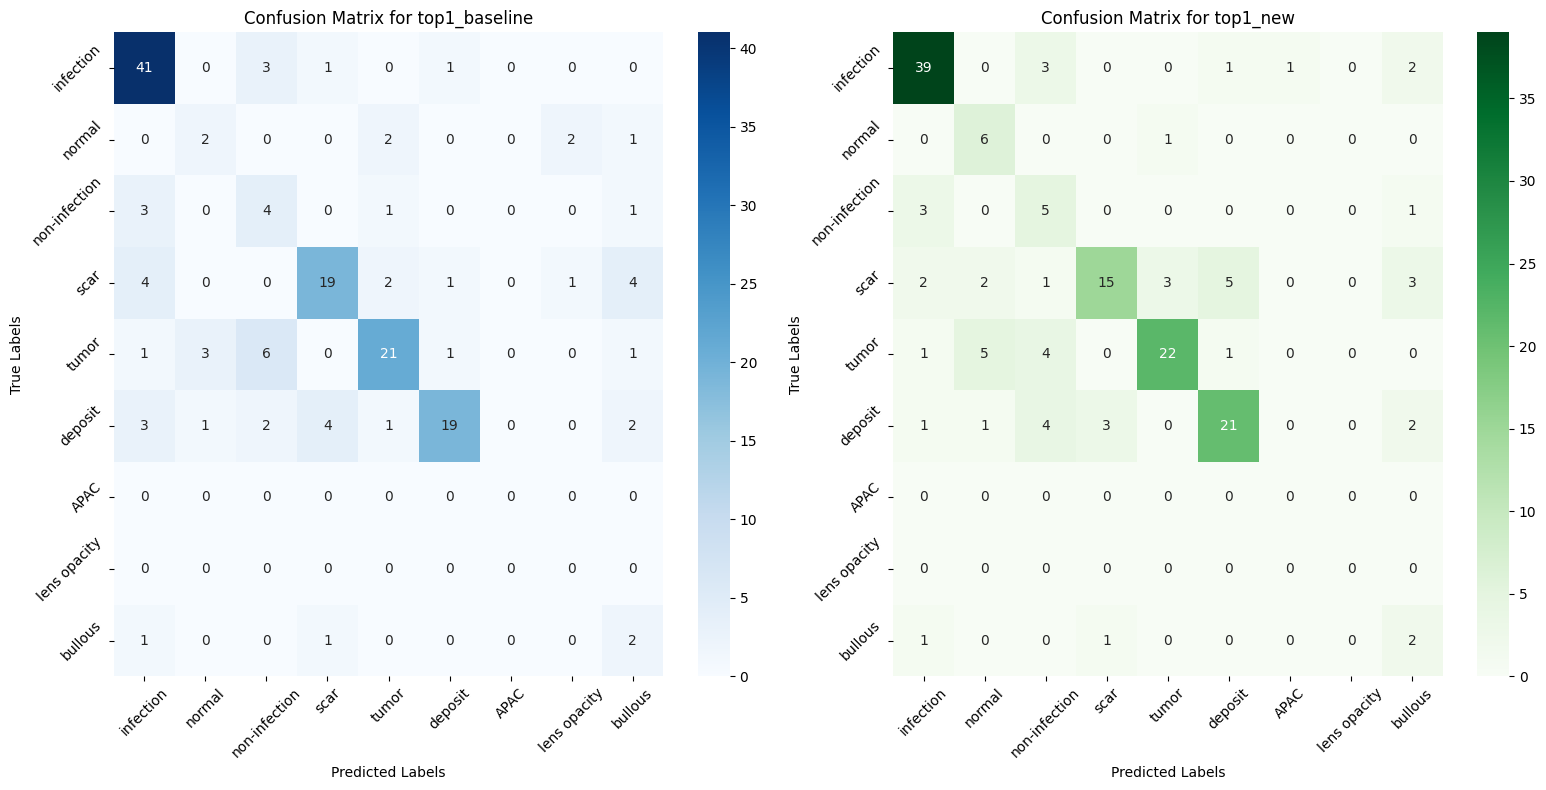

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Define the class names order
class_names_order = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "APAC", "lens opacity", "bullous"]

# Create a confusion matrix for top1_baseline
cm_baseline = confusion_matrix(df['class_name'], df['top1_baseline'], labels=class_names_order)

# Create a confusion matrix for top1_new
cm_new = confusion_matrix(df['class_name'], df['top1_new'], labels=class_names_order)

# Plotting both confusion matrices side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot for top1_baseline
sns.heatmap(cm_baseline, annot=True, ax=ax[0], fmt='d', cmap='Blues')
ax[0].set_title('Confusion Matrix for top1_baseline')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')
ax[0].set_xticklabels(class_names_order, rotation=45)
ax[0].set_yticklabels(class_names_order, rotation=45)

# Plot for top1_new
sns.heatmap(cm_new, annot=True, ax=ax[1], fmt='d', cmap='Greens')
ax[1].set_title('Confusion Matrix for top1_new')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')
ax[1].set_xticklabels(class_names_order, rotation=45)
ax[1].set_yticklabels(class_names_order, rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# Calculate accuracy for top1_baseline and top1_new
accuracy_baseline = np.trace(cm_baseline) / np.sum(cm_baseline)
accuracy_new = np.trace(cm_new) / np.sum(cm_new)

accuracy_baseline, accuracy_new



(0.6666666666666666, 0.6790123456790124)

#**Inference_Maehara_dataset**

In [ ]:
import os

# Specify the path to the zip file and the extraction directory
images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット"

# Specify the correspondence table
excel_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/対応表2022.xlsx"

baseline_weight_path = "/gdrive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
new_weight_path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/oda_dr_diverse_model/2.始めから混合データセットで学習/last.pt"

In [ ]:
import pandas as pd
# DataFrame 'df' にExcelファイルを読み込む
df = pd.read_excel(excel_path)
df.head()


In [ ]:
# maehara_dfを作成し、1列目にslit_id、2列目にdisease_Englishを含める
maehara_df = df[['basename', 'disease_English']]
maehara_df.head()


,basename,disease_English
0,HRS_104L,infection
1,21TTR_L_01,infection
2,HRS_85R,cataract
3,HRS_85L,deposit
4,HRS_136L,deposit


In [ ]:
#ファイルの存在確認
"""
import os
import pandas as pd

# Excelファイルを読み込む
excel_data = pd.read_excel(excel_path)

# 'basename'列の値を文字列に変換
excel_data['basename'] = excel_data['basename'].astype(str)

# チェックするディレクトリのパス
image_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット'

# エラーメッセージのリスト
errors = []

# 各basenameに対して、.jpgまたは.pngファイルがあるかどうかを確認
for basename in excel_data['basename']:
    jpg_file = os.path.join(image_dir, basename + '.jpg')
    JPG_file = os.path.join(image_dir, basename + '.JPG')
    png_file = os.path.join(image_dir, basename + '.png')

    if not os.path.exists(jpg_file) and not os.path.exists(png_file) and not os.path.exists(JPG_file):
        errors.append(f"Error: Neither {basename}.jpg nor {basename}.JPG nor {basename}.png exists in the directory.")

# エラーメッセージを表示
for error in errors:
    print(error)

# エラーがあるかどうかを確認
if len(errors) > 0:
    print(f"Total missing files: {len(errors)}")
else:
    print("All files are present.")
"""

Error: Neither nan.jpg nor nan.JPG nor nan.png exists in the directory.
Error: Neither nan.jpg nor nan.JPG nor nan.png exists in the directory.
Error: Neither nan.jpg nor nan.JPG nor nan.png exists in the directory.
Total missing files: 3


In [ ]:
from models.common import DetectMultiBackend
#from utils.datasets import IMG_FORMATS, VID_FORMATS, LoadImages, LoadStreams
from utils.general import (LOGGER, check_file, check_img_size, check_imshow, check_requirements, colorstr,
                           increment_path, non_max_suppression, print_args, scale_coords, strip_optimizer, xyxy2xywh)
#from utils.plots import Annotator, colors, save_one_box
#from utils.torch_utils import select_device, time_sync
from PIL import Image
import torch
from torchvision import models, transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


device = 'cpu'
#model = DetectMultiBackend(orig_weight_path, device="cpu", dnn=False)
# model = DetectMultiBackend(new_weight_path, device="cpu", dnn=False)

class_names = {0:"infection", 1:"normal", 2:"non-infection", 3:"scar", 4:"tumor", 5:"deposit", 6:"APAC", 7:"lens opacity", 8:"bullous"}

def letterbox_image(image, size=(640, 480)):
    ih, iw = image.shape[:2]
    w, h = size

    # Calculate padding to maintain aspect ratio
    scale = min(w / iw, h / ih)
    nw, nh = int(scale * iw), int(scale * ih)
    image = cv2.resize(image, (nw, nh))

    # Calculate padding dimensions
    top = (h - nh) // 2
    bottom = h - nh - top
    left = (w - nw) // 2
    right = w - nw - left

    # Add padding to the image
    return cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

def inference_top3(img_path, model):
    img_cv2 = cv2.imread(img_path)

    # Apply letterbox to the image
    img_cv2 = letterbox_image(img_cv2, size=(640, 480))
    #img_cv2 = cv2.resize(img_cv2,(640, 480))

    # Display the image using Matplotlib（表示させない場合はコメントアウトする）
    img_mpl = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    # Get current figure size
    fig_size = plt.gcf().get_size_inches()
    # Set new size (half the current size)
    plt.gcf().set_size_inches(fig_size[0] / 2, fig_size[1] / 2)

    plt.imshow(img_mpl)
    plt.axis('off')  # Turn off axis numbers
    plt.show()



    img_cv2 = img_cv2.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
    img_cv2 = np.ascontiguousarray(img_cv2)
    img_tensor = torch.from_numpy(img_cv2).float()

    img_tensor /= 255
    img_tensor = torch.unsqueeze(img_tensor, 0)  # Add batch dimension
    pred = model(img_tensor, visualize=False, augment=False)

    # multi_label=Trueにすることにより全クラスの値のlikelihoodを取得できる。数値が低いものが省略されないようconf_thres=0にしている。
    pred = non_max_suppression(pred, conf_thres=0, iou_thres=0.45, classes=None , multi_label=True, max_det=1000)

    # 全てのクラスとlikelihoodのペアを取得
    class_likelihood_pairs = [(pred[0][row][4].item(), int(pred[0][row][5].item())) for row in range(8)]

    # likelihoodで降順にソート
    class_likelihood_pairs.sort(reverse=True, key=lambda x: x[0])

    # 上位3つのクラスとlikelihoodを出力
    print("Top 3 Classes and Likelihoods:")
    for i in range(3):
        likelihood, class_num = class_likelihood_pairs[i]
        print(f"Class {class_num} ({class_names[class_num]}): Likelihood {likelihood:.5f}")

    top_classes = []
    for i in range(min(3, len(class_likelihood_pairs))):
        likelihood, class_num = class_likelihood_pairs[i]
        top_classes.append((class_num, likelihood))

    return top_classes

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
import os

# Assuming baseline_weight_path, images_dir, class_names, and other required variables are defined

model = DetectMultiBackend(baseline_weight_path, device="cpu", dnn=False)

# Ensure `maehara_df` is a standalone DataFrame
maehara_df = maehara_df.copy()

# Loop through each row in the DataFrame
for index, row in maehara_df.iterrows():
    img_id = row['basename']
    # Try different file extensions
    for ext in ['.jpg', '.png', '.JPG']:
        img_path = os.path.join(images_dir, f"{img_id}{ext}")
        if os.path.exists(img_path):
            print(f"Processing image: {img_path}")
            top3_results = inference_top3(img_path, model)

            # Update the DataFrame with the results
            for i, (class_num, likelihood) in enumerate(top3_results):
                maehara_df.loc[index, f'top{i+1}_baseline'] = class_names[class_num]
                maehara_df.loc[index, f'top{i+1}_baseline_likelihood'] = likelihood
            break
    else:
        print(f"No image found for ID {img_id} with any of the extensions .jpg, .png, .JPG")


In [ ]:
import os
import pandas as pd

# Define the path to your directory
path = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/フォトスリット"

# List all files in the directory
files = os.listdir(path)

# Filter out only PNG and JPG files
image_files = [file for file in files if file.endswith('.png') or file.endswith('.jpg')]

# Create a DataFrame and save as CSV
df = pd.DataFrame(image_files, columns=['File Name'])
csv_file = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/image_files_list.csv'
df.to_csv(csv_file, index=False)

print(f"CSV file '{csv_file}' created with list of PNG and JPG files.")


CSV file '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問/image_files_list.csv' created with list of PNG and JPG files.


#**Augmentation_ideas**

In [ ]:
import matplotlib.pyplot as plt
import cv2
import albumentations as A

# Define the path to your image
images_dir = "/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/Iris_color/taki_dr_Cornea/taki_dr_dataset"
image_path = f"{images_dir}/29.png"

# Read the image using OpenCV
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def rgb_to_bgr(img, **kwargs):
    """ Randomly convert image from RGB to BGR with a probability p. """
    p = kwargs.get('p', 0.5)  # Get the probability value from kwargs, default is 0.5
    if np.random.rand() < p:
        img = img[..., ::-1]  # Reverse the order of the first and third channel
    return img

# Define an augmentation pipeline with Albumentations
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=1),
    A.ColorJitter(brightness=0.5, hue=0.3, p=0.01),
    A.Lambda(image=rgb_to_bgr, p=0.01)  # Custom RGB to BGR conversion with a probability of 0.5
])

# Apply the augmentation pipeline to the image
augmented_img = augmentation(image=img)['image']

# Display the augmented image using matplotlib
plt.imshow(augmented_img)
plt.show()

